# Homework on two-way fixed effects

*29 September, 2021*

The goal of the following homework is to develop our understanding of two-way fixed effect models. 

Related papers:
 - the original paper by [Abowd, Kramarz, and Margolis](https://onlinelibrary.wiley.com/doi/abs/10.1111/1468-0262.00020).
 - [Andrews et al paper](https://www.jstor.org/stable/30135090)
 

## Preparing the environment

In [1]:
using Pkg
cd("/Users/xkong/Dropbox/Study/Grad@UChicago/2021Fall/Labor - Lamadon/PS1")
Pkg.activate(".") # Create new environment in this folder

# first time you need to install dependencies
Pkg.add(["Distributions","StatsBase"])
Pkg.add(["DataFrames","DataFramesMeta","Chain"])
Pkg.add(["Plots","Random","Missings"])
Pkg.add(["ShiftedArrays","CategoricalArrays"])
Pkg.add("Optim")
Pkg.add(["SparseArrays","LightGraphs"])
Pkg.add("GLM")

# past the first time, you only need to instanciate the current folder
Pkg.instantiate() # Updates packages given .toml file

  Activating environment at `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor - Lamadon/PS1/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor - Lamadon/PS1/Project.toml`
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor - Lamadon/PS1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor - Lamadon/PS1/Project.toml`
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor - Lamadon/PS1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor - Lamadon/PS1/Project.toml`
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor - Lamadon/PS1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor - Lamadon/PS1/Project.toml`
  No Changes to `~/Dropbox/Study/Grad@UChicago/2021Fall/Labor - Lamadon/PS1/Ma

We then list our imports

In [2]:
using Distributions
using LinearAlgebra
using StatsBase
using DataFrames
using Plots
using Random

global_seed = 713
Random.seed!(global_seed)

MersenneTwister(713)

## Constructing Employer-Employee matched data

### Create a mobility matrix

One central piece is to have a network of workers and firms over time. We start by simulating such an object. The rest of the homework will focus on adding wages to this model. As we know from the lectures, a central issue of the network will be the number of movers.

We are going to model the mobility between workers and firms. Given a transition matrix we can solve for a stationary distribution, and then construct our panel from there.

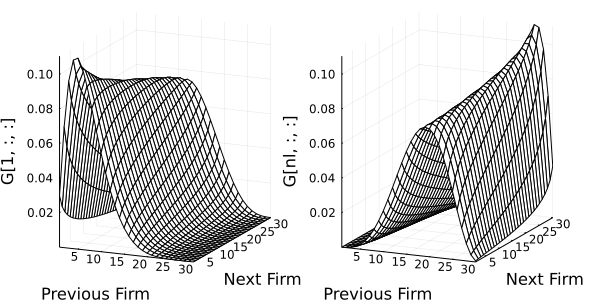

In [3]:
α_sd = 1
ψ_sd = 1

# approximate each distribution with some points of support
nk = 30
nl = 10
ψ = quantile.(Normal(), (1:nk) / (nk + 1)) * α_sd
α = quantile.(Normal(), (1:nl) / (nl + 1)) * ψ_sd

# Let's assume moving probability is fixed
λ = 0.1

csort = 0.5 # Sorting effect
cnetw = 0.2 # Network effect
csig  = 0.5 # Cross-sectional standard deviation

# Let's create type-specific transition matrices
# We are going to use joint normals centered on different values
G = zeros(nl, nk, nk)
for l in 1:nl, k in 1:nk
    G[l, k, :] = pdf( Normal(0, csig), ψ .- cnetw * ψ[k] .- csort * α[l])
    G[l, k, :] = G[l, k, :] ./ sum(G[l, k, :])
end

# We then solve for the stationary distribution over psis for each alpha value
# We apply a crude fixed point approach
H = ones(nl, nk) ./ nk
for l in 1:nl
    M = transpose(G[l, :, :])
    for i in 1:100
        H[l, :] = M * H[l, :]
    end
end

p1 = plot(G[1, :, :], xlabel="Previous Firm", ylabel="Next Firm", zlabel="G[1, :, :]", st=:wireframe)
p2 = plot(G[nl, :, :], xlabel="Previous Firm", ylabel="Next Firm", zlabel="G[nl, :, :]", st=:wireframe, right_margin = 10Plots.mm) # right_margin makes sure the figure isn't cut off on the right
plot(p1, p2, layout = (1, 2), size=[600,300])

And we can plot the joint distribution of matches

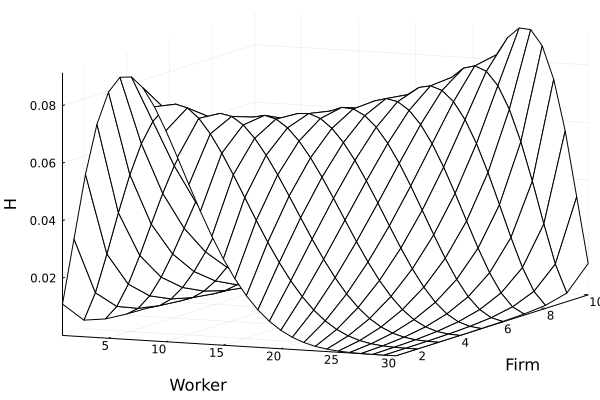

In [4]:
plot(H, xlabel="Worker", ylabel="Firm", zlabel="H", st=:wireframe)

<span style="color:green">Question 1</span>

 - Explain what the parameters `cnetw` and  `csort` do.


<span style="color:blue">Ans:</span>

`cnetw` and `csort` shift the distribution of next firm for worker `i` currently employed at firm `k` in a way that it is correlated with $\alpha[i]$ and $\psi[k]$


### Simulate a panel

The next step is to simulate our network given our transition rules.

In [5]:
nt = 10
ni = 10000

# We simulate a balanced panel
ll = zeros(Int64, ni, nt) # Worker type
kk = zeros(Int64, ni, nt) # Firm type
spellcount = zeros(Int64, ni, nt) # Employment spell, count the number of moves

for i in 1:ni
    
    # We draw the worker type
    l = rand(1:nl)
    ll[i,:] .= l
    
    # At time 1, we draw from H
    kk[i,1] = sample(1:nk, Weights(H[l, :]))
    
    for t in 2:nt
        if rand() < λ
            kk[i,t] = sample(1:nk, Weights(G[l, kk[i,t-1], :]))
            spellcount[i,t] = spellcount[i,t-1] + 1
        else
            kk[i,t] = kk[i,t-1]
            spellcount[i,t] = spellcount[i,t-1]
        end
    end
    
end

### Attach firm ids to types

The final step is to assign identities to the firms. We are going to do this is a relatively simple way, by simply randomly assigning firm ids to spells.

In [6]:
firms_per_type = 15
jj = zeros(Int64, ni, nt) # Firm identifiers

draw_firm_from_type(k) = sample(1:firms_per_type) + (k - 1) * firms_per_type

for i in 1:ni
    
    # extract firm type
    k = kk[i,1]
    
    # We draw the firm (one of firms_per_type in given group)
    jj[i,1] = draw_firm_from_type(k)
    
    for t in 2:nt
        if spellcount[i,t] == spellcount[i,t-1]
            # We keep the firm the same
            jj[i,t] = jj[i,t-1]
        else
            # We draw a new firm
            k = kk[i,t]
            
            new_j = draw_firm_from_type(k)            
            # Make sure the new firm is actually new
            while new_j == jj[i,t-1]
                new_j = draw_firm_from_type(k)
            end
            
            jj[i,t] = new_j
        end
    end
end

# Make sure firm ids are contiguous
contiguous_ids = Dict( unique(jj) .=> 1:length(unique(jj))  )
jj .= getindex.(Ref(contiguous_ids),jj);

<span style="color:green">Question 2</span>

 - Explain the last 2 lines, in particular `.=>` and the use of `Ref`. 

<span style="color:blue">Ans:</span>

The first line creates a dictionary that maps original firm ID `jj` into a list of consecutive integers. `=>` defines a pair and `.` is a broadcast operator.

The second line replaces original firm ID `jj` with those consecutive integers in the first line using `contiguous_ids` as the dictionary. `Ref` calls the dictionary `contiguous_ids`.

In [7]:
ii = repeat(1:ni,1,nt)
tt = repeat((1:nt)',ni,1)
df = DataFrame(i=ii[:], j=jj[:], l=ll[:], k=kk[:], α=α[ll[:]], ψ=ψ[kk[:]], t=tt[:], spell=spellcount[:]);
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,i,5000.5,1,5000.5,10000,0,Int64
2,j,183.6,1,178.0,444,0,Int64
3,l,5.4651,1,5.0,10,0,Int64
4,k,15.4229,1,15.0,30,0,Int64
5,α,-0.00920911,-1.33518,-0.114185,1.33518,0,Float64
6,ψ,-0.00761936,-1.8486,-0.0404405,1.8486,0,Float64
7,t,5.5,1,5.5,10,0,Int64
8,spell,0.45321,0,0.0,6,0,Int64


<span style="color:green">Question 3</span>

Use `Chain.jl` and `DataFramesMeta.jl` to compute:

 - mean firm size, in the crossection, expect something like 15.
 - mean number of movers per firm in total in our panel.


<span style="color:blue">Ans:</span>

As computed below, mean firm size in the crossection is around 23, and mean number of movers per firm in total is around 20.

In [8]:
using Chain, DataFramesMeta

sort!(df, [:i, :t]) # sort by i, t

df_mean_size = @chain df begin
    @transform!(:n = 1) # add a column of ones
    groupby([:j,:t]) # group by j, t
    combine(:n => sum => :size) # count the number of workers in (j,t)
    groupby([:t]) # group by t
    combine(:size => mean => :mean_size) # calculate the average number of workers for each t
end

,t,mean_size
,Int64,Float64
1,1,22.6244
2,2,22.8833
3,3,22.8833
4,4,22.8833
5,5,22.8833
6,6,22.8833
7,7,22.779
8,8,22.779
9,9,22.8833


In [9]:
using ShiftedArrays

# describe(df[:,:spell])

function mean_num_movers(df)
    mean_num_movers = @chain df begin
        groupby([:i])
        combine(:i, :j, :t, :j => lead => :j_lead) # generate lead variable for j
        @transform!(:move = (:j .!= :j_lead) .* 1) # move if current j and next j are different
        transform(:move => (x -> ifelse.(ismissing.(x), 0, x)) => :move) # deal with missing values
        groupby([:j])
        combine(:move => sum => :move_total) # total number of movers in j
        mean(_.move_total) # average number of movers
    end
    return mean_num_movers
end

mean_movers = mean_num_movers(df)

20.10810810810811

## Simulating AKM wages and create Event Study plot

We start with just AKM wages, which is log additive with some noise.

In [10]:
w_sigma = 0.2
df[!, :lw] = df.α + df.ψ + w_sigma * rand(Normal(), size(df)[1]);

<span style="color:green">Question 4</span>

Before we finish with the simulation code. Use this generated data to create the event study plot from [Card. Heining, and Kline](https://doi.org/10.1093/qje/qjt006):

1. Compute the mean wage within firm
2. Group firms into quartiles
3. Select workers around a move (2 periods pre, 2 periods post)
4. Compute wages before/after the move for each transition (from each quartile to each quartile)
5. Plot the lines associated with each transition

<span style="color:blue">Ans:</span>

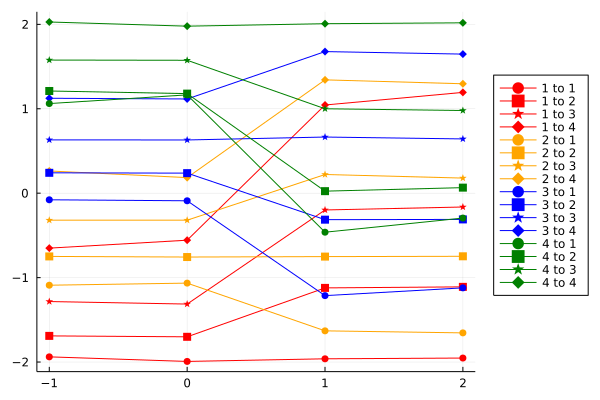

In [11]:
using CategoricalArrays

# Steps 1-2
# get firm mean wage and its quartile
df_firm_quartile = @chain df begin
    groupby(:j)
    combine(:lw => mean => :lw_firm_mean) # mean wage in j
    @transform!(:quartile = levelcode.(cut(:lw_firm_mean, 4))) # get quartile
    select!(Not([:lw_firm_mean]))
end

# Steps 3-4
df_mean_wage = @chain df begin
    # find movers
    groupby(:i)
    transform(:j => lead => :j_lead)
    @transform!(:move = (:j .!= :j_lead) .* 1)
    transform(:move => (x -> ifelse.(ismissing.(x), 0, x)) => :move)
    
    # find the period of move and the firm before and after move
    @transform!(:move_from_j = :move .* :j)
    transform(:j_lead => (x -> ifelse.(ismissing.(x), 0, x)) => :j_lead)
    @transform!(:move_to_j = :move .* :j_lead)
    @transform!(:move_t = :move .* :t)
    groupby(:i)
    transform(:move_t => maximum => :move_t)
    groupby(:i)
    transform(:move_from_j => maximum => :move_from_j)
    groupby(:i)
    transform(:move_to_j => maximum => :move_to_j)
    
    # number of moves for i
    groupby(:i)
    transform(:move => sum => :move_total)
    
    # keep movers who only move once
    # keep movers who have 2 periods of data both before and after move
    @transform!(:event_t = :t-:move_t)
    @subset(:event_t.>=-1, :event_t.<=2, :move_total.==1, :move_t.>1, :move_t.<9)
    
    # merge on firm quartile
    innerjoin(_, df_firm_quartile, on = [:move_from_j => :j])
    rename!(:quartile => :quartile_pre)
    innerjoin(_, df_firm_quartile, on = [:move_to_j => :j])
    rename!(:quartile => :quartile_post)
    
    # calculate mean wage by firm quartile pair
    groupby([:quartile_pre,:quartile_post,:event_t])
    combine(:lw => mean => :lw_mean)
end

# plot
p = plot()
for (pre, color) in zip(1:4, [:red, :orange, :blue, :green])
    for (post, marker) in zip(1:4, [:circle, :rect, :star5, :diamond])
        df_temp = @subset(df_mean_wage, :quartile_pre.==pre, :quartile_post.==post)
        plot!(df_temp.event_t, df_temp.lw_mean, 
            linecolor = color, 
            markershape = marker, 
            markercolor = color,
            markerstrokewidth = 0,
            label = "$pre to $post",
            legend = :outerright)
    end
end
display(p)

## Calibrating the parameters

<span style="color:green">Question 5</span>

 - Pick the parameters `psi_sd`, `alpha_sd`, `csort`, `csig`, and `w_sigma` to roughly match the decomposition in the Card-Heining-Kline paper (note that they often report numbers in standard deviations, not in variances).

<span style="color:blue">Ans:</span>

In [12]:
function simulate_moment(param; get_df = 0, mob = 0.1, T = 10)
    
    α_sd = param[1]
    ψ_sd = param[2]
    csort = param[3]
    csig = param[4]
    w_sigma = param[5]
    
    # α_sd = 1
    # ψ_sd = 1

    # approximate each distribution with some points of support
    nk = 30
    nl = 10
    ψ = quantile.(Normal(), (1:nk) / (nk + 1)) * α_sd
    α = quantile.(Normal(), (1:nl) / (nl + 1)) * ψ_sd

    # Let's assume moving probability is fixed
    λ = mob

    # csort = 0.5 # Sorting effect
    cnetw = 0.2 # Network effect
    # csig  = 0.5 # Cross-sectional standard deviation

    # Let's create type-specific transition matrices
    # We are going to use joint normals centered on different values
    G = zeros(nl, nk, nk)
    for l in 1:nl, k in 1:nk
        G[l, k, :] = pdf( Normal(0, csig), ψ .- cnetw * ψ[k] .- csort * α[l])
        G[l, k, :] = G[l, k, :] ./ sum(G[l, k, :])
    end

    # We then solve for the stationary distribution over psis for each alpha value
    # We apply a crude fixed point approach
    H = ones(nl, nk) ./ nk
    for l in 1:nl
        M = transpose(G[l, :, :])
        for i in 1:100
            H[l, :] = M * H[l, :]
        end
    end

    nt = T
    ni = 10000

    # We simulate a balanced panel
    ll = zeros(Int64, ni, nt) # Worker type
    kk = zeros(Int64, ni, nt) # Firm type
    spellcount = zeros(Int64, ni, nt) # Employment spell, count the number of moves

    for i in 1:ni

        # We draw the worker type
        l = rand(1:nl)
        ll[i,:] .= l

        # At time 1, we draw from H
        kk[i,1] = sample(1:nk, Weights(H[l, :]))

        for t in 2:nt
            if rand() < λ
                kk[i,t] = sample(1:nk, Weights(G[l, kk[i,t-1], :]))
                spellcount[i,t] = spellcount[i,t-1] + 1
            else
                kk[i,t] = kk[i,t-1]
                spellcount[i,t] = spellcount[i,t-1]
            end
        end

    end
    
    
    firms_per_type = 15
    jj = zeros(Int64, ni, nt) # Firm identifiers

    draw_firm_from_type(k) = sample(1:firms_per_type) + (k - 1) * firms_per_type

    for i in 1:ni

        # extract firm type
        k = kk[i,1]

        # We draw the firm (one of firms_per_type in given group)
        jj[i,1] = draw_firm_from_type(k)

        for t in 2:nt
            if spellcount[i,t] == spellcount[i,t-1]
                # We keep the firm the same
                jj[i,t] = jj[i,t-1]
            else
                # We draw a new firm
                k = kk[i,t]

                new_j = draw_firm_from_type(k)            
                # Make sure the new firm is actually new
                while new_j == jj[i,t-1]
                    new_j = draw_firm_from_type(k)
                end

                jj[i,t] = new_j
            end
        end
    end

    # Make sure firm ids are contiguous
    contiguous_ids = Dict( unique(jj) .=> 1:length(unique(jj))  )
    jj .= getindex.(Ref(contiguous_ids),jj);
    
    
    ii = repeat(1:ni,1,nt)
    tt = repeat((1:nt)',ni,1)
    df = DataFrame(i=ii[:], j=jj[:], l=ll[:], k=kk[:], α=α[ll[:]], ψ=ψ[kk[:]], t=tt[:], spell=spellcount[:]);
    
    # w_sigma = 0.2
    df[!, :lw] = df.α + df.ψ + w_sigma * rand(Normal(), size(df)[1]);

    # Compute simulated moments
    lw_std_sim = std(df.lw)
    α_sd_sim = std(df.α)
    ψ_sd_sim = std(df.ψ)
    αψ_corr_sim = cor(df.α, df.ψ)
    ϵ_sd_sim = std(df.lw - (df.α + df.ψ))
    
    if get_df == 1
        return(df)
    else
        return (lw_std_sim, α_sd_sim, ψ_sd_sim, αψ_corr_sim, ϵ_sd_sim)
    end
    
end

simulate_moment (generic function with 1 method)

In [13]:
using Optim

Random.seed!(global_seed)
moment_data = [0.499, 0.357, 0.230, 0.249, 0.122] # Numbers from Table III, column (4)
param_init = 0.5.*ones(5)

results = optimize(x -> sum((simulate_moment(x) .- moment_data).^2), param_init, g_tol = 1e-6, show_trace = false)

param_sol = results.minimizer
println("Calibrated parameters are given by $param_sol")
moment_sim = simulate_moment(param_sol)
println("Moments under the calibrated parameters are $moment_sim")

Calibrated parameters are given by [0.2682873204255686, 0.45752671164527, 0.911834278431373, 0.5478264451573757, 0.12363359088994888]
Moments under the calibrated parameters are (0.49217818968977395, 0.36205797035786724, 0.23252716845266774, 0.24660652864730132, 0.12380865842436309)


## Estimating two-way fixed effects

This requires first extracting the large set of firms connected by movers, and then estimating the linear problem with many dummies.

### Extracting the connected set

Because we are not going to deal with extremely large data-sets, we can use off-the-shelf algorithms to extract the connected set. Use the function `connected_components` from the package `LightGraphs` to extract the connected set from our data. To do so you will need to first construct an adjacency matrix between the firms. 

<span style="color:green">Question 6</span>

 - Extract the connected set and drop firms not in the set (I expect that all firms will be in the set).

<span style="color:blue">Ans:</span>

In [14]:
# use the new data with calibrated parameters
df = simulate_moment(param_sol; get_df = 1)

sort!(df, [:i, :t])

using SparseArrays, LightGraphs

adj_mat = @chain df begin
    groupby([:i])
    combine(:i, :j, :t, :j => lead => :j_lead)
    @transform!(:move = (:j .!= :j_lead) .* 1)
    transform(:move => (x -> ifelse.(ismissing.(x), 0, x)) => :move)
    @subset(:move.==1)
    sparse(_.j, _.j_lead, ones(size(_)[1]))
end

adj_mat = ((adj_mat + adj_mat') .> 0) .* 1

# check if all firms are connected 
g = SimpleGraph(adj_mat)
connected_components(g)

1-element Vector{Vector{Int64}}:
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  441, 442, 443, 444, 445, 446, 447, 448, 449, 450]

### Estimating worker and firm FEs

This part of the problem set is for you to implement the AKM estimator. As discussed in class, this can be done simply by updating, in turn, the worker FE and the firm FE.

Start by appending 2 new columns `alpha_hat` and `psi_hat` to your data. Then loop over the following:

1. Update `alpha_hat` by taking the mean within `i` net of firm FE
2. Update `psi_hat` by taking the mean within `fid` net of worker FE

<span style="color:green">Question 7</span>

 - Run the previous steps in a loop, and at each step evaluate how much the total mean square error has changed. Check that is goes down with every step. Stop when the MSE decreases by less than 1e-9.


Note that you can increase speed by focusing on movers only first.



<span style="color:blue">Ans:</span>


In [15]:
function estimate_FE(df, α_hat_init, ψ_hat_init, Dmse_tol; print = 1)

    Dmse = 1
    mse0 = 1

    df[!,:α_hat] .= α_hat_init
    df[!,:ψ_hat] .= ψ_hat_init

    df_iter = df
    iter_count = 0
    while Dmse > Dmse_tol
        iter_count = iter_count + 1
        df_iter = @chain df_iter begin
            @transform!(:α_hat_temp = :lw .- :ψ_hat)
            groupby(:i)
            transform(:α_hat_temp => mean => :α_hat)

            @transform!(:ψ_hat_temp = :lw .- :α_hat)
            groupby(:j)
            transform(:ψ_hat_temp => mean => :ψ_hat)
        end

        mse1 = mean((df_iter.lw .- df_iter.α_hat .- df_iter.ψ_hat).^2)
        Dmse = mse0 - mse1
        if print == 1
            println("Decrease in MES in iteration $iter_count is $Dmse")
        end
        mse0 = mse1
    end
    
    return df_iter
end

Dmse_tol = 1e-9
α_hat_init = 0.1
ψ_hat_init = 0.1

df_iter = estimate_FE(df, α_hat_init, ψ_hat_init, Dmse_tol);

Decrease in MES in iteration 1 is 0.9762976366291769
Decrease in MES in iteration 2 is 0.004620885521073821
Decrease in MES in iteration 3 is 0.0024050324308643213
Decrease in MES in iteration 4 is 0.0012918351222192485
Decrease in MES in iteration 5 is 0.0007136754484579344
Decrease in MES in iteration 6 is 0.0004041511157748742
Decrease in MES in iteration 7 is 0.00023386605931712684
Decrease in MES in iteration 8 is 0.00013788864332357938
Decrease in MES in iteration 9 is 8.262801530613609e-5
Decrease in MES in iteration 10 is 5.02118639682924e-5
Decrease in MES in iteration 11 is 3.088469533485405e-5
Decrease in MES in iteration 12 is 1.919723106094326e-5
Decrease in MES in iteration 13 is 1.2042062111781299e-5
Decrease in MES in iteration 14 is 7.614352275534669e-6
Decrease in MES in iteration 15 is 4.848623688888734e-6
Decrease in MES in iteration 16 is 3.106773919101663e-6
Decrease in MES in iteration 17 is 2.001781886562179e-6
Decrease in MES in iteration 18 is 1.29628017501992

## Limited mobility bias

We now have everything we need to look at the impact of limited mobility bias. Compute the following:

1. Compute the estimated variance of firm FE
2. Do it for varying levels of mobility λ. For each the number of movers, collect the actual variance and the estimated variance. Run it for different panel lengths: 5, 6, 8, 10, 15.

<span style="color:green">Question 8</span>

 - Report this in a plot. This should look like the [Andrews et al.](https://www.sciencedirect.com/science/article/pii/S0165176512004272) plot.

<span style="color:blue">Ans:</span>

In [16]:
mob_vec = [0.02, 0.04, 0.06, 0.08, 0.1]
T_vec = [5, 6, 8, 10, 15]

output = zeros(size(mob_vec)[1], 5, size(T_vec)[1])

Dmse_tol = 1e-9
α_hat_init = 0.1
ψ_hat_init = 0.1

for i in 1:size(T_vec)[1]
    T = T_vec[i]
    for j in 1:size(mob_vec)[1]
        Random.seed!(global_seed)

        mob = mob_vec[j]
        
        df_temp = simulate_moment(param_sol; get_df = 1, mob = mob, T = T)
        df_temp = estimate_FE(df_temp, α_hat_init, ψ_hat_init, Dmse_tol; print = 0)
        
        df_temp_firm_FE = combine(groupby(df_temp, :j), :ψ => mean => :ψ_act, :ψ_hat => mean => :ψ_est)
        
        output[j,1,i] = mean_num_movers(df_temp)
        output[j,2,i] = var(df_temp_firm_FE.ψ_act)
        output[j,3,i] = var(df_temp_firm_FE.ψ_est)
        output[j,4,i] = cor(df_temp.α, df_temp.ψ)
        output[j,5,i] = cor(df_temp.α_hat, df_temp.ψ_hat)
    end
end

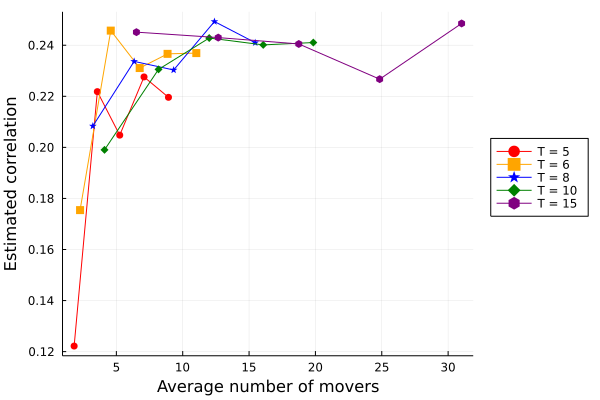

In [17]:
# plot - estimated correlation between alpha and psi
corr_plot = plot()
for (i, color, marker) in zip(1:size(T_vec)[1], [:red, :orange, :blue, :green, :purple], [:circle, :rect, :star5, :diamond, :hexagon])
    T = T_vec[i]
    plot!(output[:,1,i], output[:,5,i], 
        linecolor = color, 
        markershape = marker, 
        markercolor = color,
        markerstrokewidth = 0,
        label = "T = $T",
        legend = :outerright)
end
xlabel!("Average number of movers")
ylabel!("Estimated correlation")
display(corr_plot)

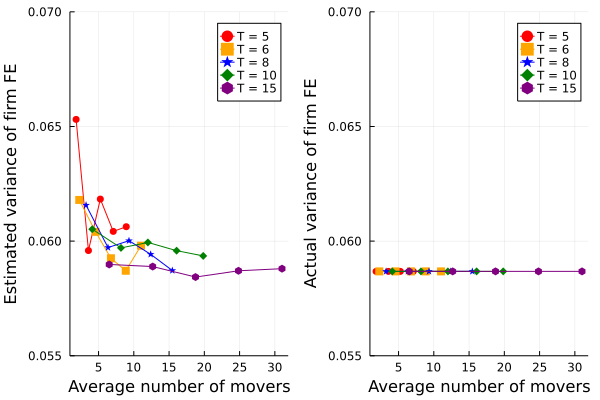

In [18]:
# plot - actual variance of firm FE
var_act_plot = plot()
for (i, color, marker) in zip(1:size(T_vec)[1], [:red, :orange, :blue, :green, :purple], [:circle, :rect, :star5, :diamond, :hexagon])
    T = T_vec[i]
    plot!(output[:,1,i], output[:,2,i], 
        linecolor = color, 
        markershape = marker, 
        markercolor = color,
        markerstrokewidth = 0,
        label = "T = $T",
        legend = :topright,
        ylims = (0.055, 0.07))
end
xlabel!("Average number of movers")
ylabel!("Actual variance of firm FE")

# plot - estimated variance of firm FE
var_est_plot = plot()
for (i, color, marker) in zip(1:size(T_vec)[1], [:red, :orange, :blue, :green, :purple], [:circle, :rect, :star5, :diamond, :hexagon])
    T = T_vec[i]
    plot!(output[:,1,i], output[:,3,i], 
        linecolor = color, 
        markershape = marker, 
        markercolor = color,
        markerstrokewidth = 0,
        label = "T = $T",
        legend = :topright,
        ylims = (0.055, 0.07))
end
xlabel!("Average number of movers")
ylabel!("Estimated variance of firm FE")

plot(var_est_plot, var_act_plot, layout = (1, 2))

## Correcting the bias

<span style="color:green">Question 9</span>

 - Implement both the exact as well as the approximated (Hutchkinson trace approximation) Andrews et al. type fixed-effect bias correction based on homoskedacity. Redo the plot from Question 6 so that it includes these 2 estimates.

<span style="color:blue">Ans:</span>

In [19]:
function bias_correction(df)

    NT = size(df)[1]
    nj = length(unique(df.j))

    A_α = sparse(zeros(NT, ni))
    for i in 1:NT
        A_α[i,df.i[i]] = 1
    end

    A_ψ = sparse(zeros(NT, nj))
    for i in 1:NT
        A_ψ[i,df.j[i]] = 1
    end

    # A = hcat(A_α, A_ψ)

    df = estimate_FE(df, α_hat_init, ψ_hat_init, Dmse_tol; print = 0);
    var_eps = mean((df.lw - df.α_hat - df.ψ_hat).^2)

    part1 = inv(Matrix(A_ψ'*A_ψ - A_ψ' * A_α*inv(Matrix(A_α'*A_α))*A_α' * A_ψ))
    part2 = A_ψ'*A_ψ - (A_ψ'*ones(NT,NT)*A_ψ) ./ NT
    part3 = part1 * part2
    bias_exact = var_eps .* tr(part3) ./ NT
    
    # draw Rademacher random vectors
    num_draw = 10
    trace_approx = zeros(num_draw,1)
    for i in 1:num_draw
        Rademacher = rand(nj,1)
        Rademacher = ifelse.(Rademacher .< 0.5, -1, 1)
        trace_approx[i] = (Rademacher' * part3 * Rademacher)[1]
    end
    bias_approx = var_eps .* mean(trace_approx) ./ NT
    
    return (bias_exact, bias_approx)
end

bias_correction (generic function with 1 method)

In [20]:
mob_vec = [0.02, 0.04, 0.06, 0.08, 0.1]

bias = zeros(size(mob_vec)[1], 3)

Dmse_tol = 1e-9
α_hat_init = 0.5
ψ_hat_init = 0.5

for j in 1:size(mob_vec)[1]
    Random.seed!(global_seed)
    
    mob = mob_vec[j]
        
    df_temp = simulate_moment(param_sol; get_df = 1, mob = mob, T = 10)
    df_temp = estimate_FE(df_temp, α_hat_init, ψ_hat_init, Dmse_tol; print = 0)
        
    bias1, bias2 = bias_correction(df_temp)
        
    bias[j,1] = mean_num_movers(df_temp)
    bias[j,2] = bias1
    bias[j,3] = bias2
end

In [21]:
# Q_αα = A_α'*A_α - (A_α'*ones(NT,NT)*A_α) ./ NT
# Q_ψψ = A_ψ'*A_ψ - (A_ψ'*ones(NT,NT)*A_ψ) ./ NT
# Q_αψ = zeros(ni,nj)
# Q = hcat([Q_αα; Q_αψ'], [Q_αψ; Q_ψψ])

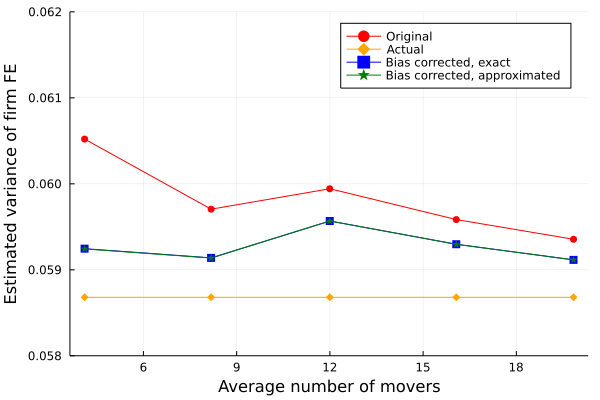

In [22]:
plot(output[:,1,4], output[:,3,4], 
    linecolor = :red, markershape = :circle, markercolor = :red, markerstrokewidth = 0, label = "Original")
plot!(output[:,1,4], output[:,2,4], 
    linecolor = :orange, markershape = :diamond, markercolor = :orange, markerstrokewidth = 0, label = "Actual")
plot!(output[:,1,4], output[:,3,4]-bias[:,2], 
    linecolor = :blue, markershape = :rect, markercolor = :blue, markerstrokewidth = 0, label = "Bias corrected, exact")
plot!(output[:,1,4], output[:,3,4]-bias[:,3], 
    linecolor = :green, markershape = :star5, markercolor = :green, markerstrokewidth = 0, label = "Bias corrected, approximated", legend = :topright, ylims = (0.058, 0.062))
xlabel!("Average number of movers")
ylabel!("Estimated variance of firm FE")

## Evidence of learning

<span style="color:green">Question 10</span>

 - Regress the wage of a worker at time $t$ on his wage at time $t-l$ and the average wage of his co-workers at time $t-l$ for some lags $l$ focusing on workers that did change firms between $t-l$ and $t$. 
 - Comment on the result.


<span style="color:blue">Ans:</span>

In [23]:
using GLM

ell = 2

df_firm = @chain df begin
    @transform!(:N = 1)
    groupby([:j,:t])
    combine(:N => sum => :num_worker, :lw => sum => :lw_total)
end

df_learning = @chain df begin
    leftjoin(_, df_firm, on = [:j,:t])
    @transform!(:lw_coworker = (:lw_total .- :lw) ./ (:num_worker .- 1))
    
    groupby(:i)
    transform(:lw => (x -> lag(x, ell)) => :lw_lag)
    groupby(:i)
    transform(:lw_coworker => (x -> lag(x, ell)) => :lw_coworker_lag)
    groupby(:i)
    transform(:j => (x -> lag(x, ell)) => :j_lag)
    
    @subset(:j.!=:j_lag)
end

reg_result = lm(@formula(lw ~ lw_lag + lw_coworker), df_learning)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

lw ~ 1 + lw_lag + lw_coworker

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error       t  Pr(>|t|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)  0.000769456  0.00188475    0.41    0.6831  -0.00292487  0.00446378
lw_lag       0.626372     0.00395212  158.49    <1e-99   0.618626    0.634119
lw_coworker  0.745581     0.0057997   128.56    <1e-99   0.734213    0.756949
───────────────────────────────────────────────────────────────────────────────